In [3]:
# from keras.optimizers import Adam, RMSprop, Adadelta 
# %tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot  as plt
import IPython.display as ipd
import librosa, os, keras.utils, tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Conv2DTranspose, Conv1D, concatenate
from keras.layers import BatchNormalization, LSTM, Reshape, Input
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing as prep 
# from google.colab import drive
# drive.mount('/content/drive')

# Подготовка данных


# Функции для обработки данных...


In [ ]:
''' Получение меток из папки с примерами голосовых комманд
    при заполнении новыми данными ,будут получены новые метки  '''
# получаем путь к папке с наборами структурированных данных
# в папке лежат записи звуков команд различным произношением (медленное,быстрое,высоким, низким..)
# в идеале нужно записать голова всех членов семьи - это позволит выделять команды хозяев дома от гостей
# при включении соответствующего режима

def get_labels(path=DATA_PATH):
  labels = sorted(os.listdir(path))
  lab_in = np.arange(0, len(labels))
  return labels, lab_in, to_categorical(lab_in)
labels, lab_in, lab_to_cat = get_labels(path=DATA_PATH)
print(labels,'\n',lab_in,'\n', lab_to_cat)

['1BigRoom', '2Door', '3CamNo3', 'Noise'] 
 [0 1 2 3] 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Пример функции для извлечения полных параметров данных из файла

In [ ]:
def get_features_all(y, sr):
  #Получаем различные параметры аудио которые в сумме дадут уникальный набор признаков
  chst = librosa.feature.chroma_stft(y=y, sr=sr)          # Частота цветности
  rmse = librosa.feature.rms(y=y)                         # КОЛЕБАНИЯ
  zcr = librosa.feature.zero_crossing_rate(y)             # Пересечения нуля
  spe_c = librosa.feature.spectral_centroid(y=y, sr=sr)   # ЦЕНТР МАСС ЗВУКА 
  spe_b = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Ширина полосы частот
  rol = librosa.feature.spectral_rolloff(y=y, sr=sr)      # Спектральный спад частоты
  mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=50,   # ПОЛУЧАЕМ ЗНАЧИМЫЕ ДЛЯ ОБРАБОТКИ ЧАСТОТЫ 
                              n_mels=50, hop_length=1024)
  
  return chst, rmse, zcr, spe_c, spe_b, rol, mfcc

In [ ]:
file_way = '/content/drive/MyDrive/1.0AudioSmartHomme/comands/2Door/OpenDoor (18).wav'
yTr, srTr = librosa.load((file_way),sr=SR,mono=True,
                         offset=None,duration=None) 
print(f'Загрузили Y данные {yTr} \n C частотой дискретизации {srTr}\n ИЗ НИХ ПОЛУЧИЛИ:')
chst, rmse, zcr, spe_c, spe_b, rol, mfcc = get_features_all(yTr, 22050)
print(f'chst {chst.shape}:\n {chst}\n')
print(f'rmse {rmse.shape}:\n {rmse}\n')
print(f'zcr {zcr.shape}:\n {zcr}\n')
print(f'spe_c {spe_c.shape}:\n {spe_c}\n')
print(f'spe_b {spe_b.shape}:\n {spe_b}\n')
print(f'rol {rol.shape}:\n {rol}\n')
print(f'mfcc {mfcc.shape}:\n {mfcc}')

Загрузили Y данные [ 0.          0.          0.         ... -0.00064526 -0.00058522
 -0.00035552] 
 C частотой дискретизации 22050
 ИЗ НИХ ПОЛУЧИЛИ:
chst (12, 138):
 [[0.7276802  1.         0.9285354  ... 0.66054595 0.7142373  0.62990904]
 [0.72317415 0.8107146  0.771444   ... 0.6331197  0.90561104 0.88495433]
 [0.49670035 0.6628981  0.5575063  ... 0.5406687  0.7535429  0.7788358 ]
 ...
 [0.8006085  0.86232877 0.8208471  ... 0.340938   0.44641584 0.6934038 ]
 [0.58170074 0.8728709  1.         ... 0.32472026 0.23069867 0.41239998]
 [0.59023696 0.7921724  0.8812276  ... 0.60415417 0.34606686 0.336244  ]]

rmse (1, 138):
 [[0.00040858 0.000621   0.00081081 0.00094945 0.00102799 0.00110812
  0.00111254 0.00110364 0.00107393 0.00091298 0.00085206 0.00088445
  0.00157191 0.00178992 0.00187808 0.00186895 0.00136554 0.00108898
  0.00098163 0.00104023 0.00103235 0.00104954 0.00100427 0.00087091
  0.00080998 0.00070519 0.00063623 0.00058081 0.00059014 0.0005742
  0.00059504 0.0006215  0.00059854

### Вижу что наборы значений сильно отличается между собой, там где цифровые значения низкие, будут менее значимы при объединее. 
### Можно использовать вариант с нормализвцией данных, где все значения перейдут в диапазон значений 0~1 и после объединить. А можно использовать вариант с несколькими входами.

## Визуализация данных. 
Отображаем для *визуального сравнения*, данные не потеряли свою уникальность.
Визуально графики совпадают. Сравнение типа булево == True/False здесь не возможно сделать, т.к. значения разные, по этому делаем визуализацию.

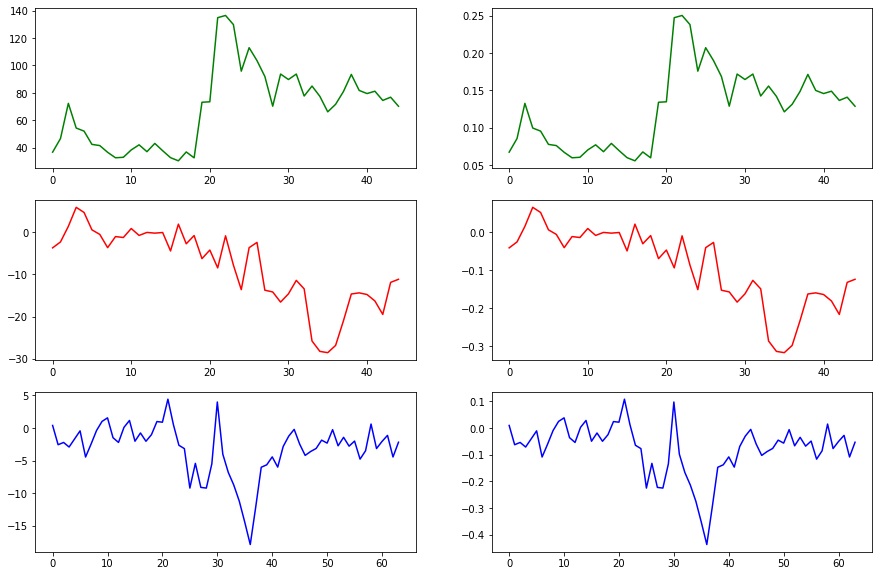

In [ ]:
# Отображаем значения графически у ненормализованных данных

plt.figure(figsize=(15,10))

plt.subplot(321,)
plt.plot(mfcc.T[5:50,1],'g')
plt.subplot(323)
plt.plot(mfcc.T[5:50,10],'r') 
plt.subplot(325)
plt.plot(mfcc.T[5:,30],'b') 

# Проведу нормализацию значений данных пакетом normalize из библиотеки librosa
mfc_c = prep.normalize(mfcc)    # НОРМАЛИЗАЦИЯ ЗНАЧЕНИЙ

# Вывожу те-же данные но уже с нормализованными значениями

plt.subplot(322,)
plt.plot(mfc_c.T[5:50,1],'g')
plt.subplot(324)
plt.plot(mfc_c.T[5:50,10],'r') 
plt.subplot(326)
plt.plot(mfc_c.T[5:,30],'b') 
plt.show()

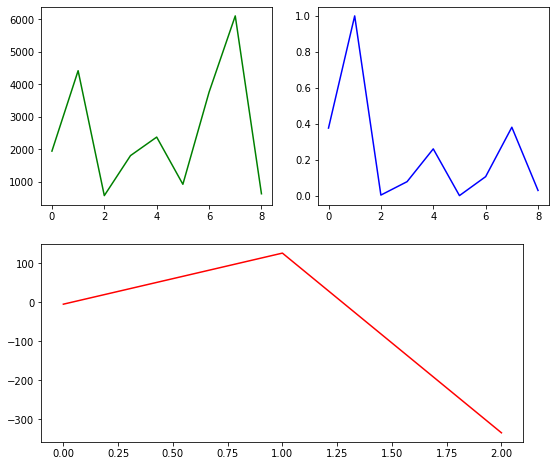

In [ ]:
plt.figure(figsize=(19,8))
plt.subplot(241,)
plt.plot(ssr,'g')
plt.subplot(242)
plt.plot(crz,'b') 
plt.subplot(223)
plt.plot(mfc,'r') 
plt.show()

# Визуализируем полученные данные от файла.
*это позволит наглядно понять что имеем от каждого файла, в каком объёме и диапазоне. по результатам принимаем решение как можем использовать эти данные для достижения результата.*

**Для получения большего количства параметров выхватываем из данных среднее, минимальное и максимальные значения.**

In [ ]:
def get_featur_mean(y, sr):
  #Получаем различные параметры аудио которые в сумме дадут уникальный набор признаков
  chst1 = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))            # Частота цветности
  chst2 = np.max(librosa.feature.chroma_stft(y=y, sr=sr))
  chst3 = np.min(librosa.feature.chroma_stft(y=y, sr=sr))

  rmse1 = np.mean(librosa.feature.rms(y=y))                           # СРЕДНЕКВАДРАТИЧНЫЕ КОЛЕБАНИЯ
  rmse2 = np.max(librosa.feature.rms(y=y))
  rmse3 = np.min(librosa.feature.rms(y=y))  

  zcr1 = np.mean(librosa.feature.zero_crossing_rate(y))               # Пересечения нуля
  zcr2 = np.max(librosa.feature.zero_crossing_rate(y))
  zcr3 = np.min(librosa.feature.zero_crossing_rate(y))

  spe_c1 = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))     # ЦЕНТР МАСС ЗВУКА 
  spe_c2 = np.max(librosa.feature.spectral_centroid(y=y, sr=sr))
  spe_c3 = np.min(librosa.feature.spectral_centroid(y=y, sr=sr))

  spe_b1 = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))    # Ширина полосы частот
  spe_b2 = np.max(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  spe_b3 = np.min(librosa.feature.spectral_bandwidth(y=y, sr=sr))

  rol1 = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))        # Спектральный спад частоты
  rol2 = np.max(librosa.feature.spectral_rolloff(y=y, sr=sr))
  rol3 = np.min(librosa.feature.spectral_rolloff(y=y, sr=sr))
  
  mfc1 = np.mean(librosa.feature.mfcc(y=y, sr=SR, n_mfcc=50,     # ПОЛУЧАЕМ ЗНАЧИМЫЕ ДЛЯ ОБРАБОТКИ ЧАСТОТЫ 
                n_mels=50, hop_length=1024))
  mfc2 = np.max(librosa.feature.mfcc(y=y, sr=SR, n_mfcc=50, 
                n_mels=50, hop_length=1024))
  mfc3 = np.min(librosa.feature.mfcc(y=y, sr=SR, n_mfcc=50, 
                n_mels=50, hop_length=1024))
  
  ssr = []              # Создаю пустой список в который добавлю полученные значения
  ssr.append(spe_c1)    # центра масс звука, ширина частоты звука и спектральный спад 
  ssr.append(spe_c2)
  ssr.append(spe_c3)
  ssr.append(spe_b1)
  ssr.append(spe_b2)
  ssr.append(spe_b3)
  ssr.append(rol1)
  ssr.append(rol2)
  ssr.append(rol3)
  crz = []              # Создаю пустой список в который добавлю полученные значения
  crz.append(chst1)     # Более простые данные и извлеченные из них параметры при этом не менее значимые
  crz.append(chst2)     # они помогут в совокупности с другими получить уникальный "слепок" с данных
  crz.append(chst3)
  crz.append(rmse1)
  crz.append(rmse2)
  crz.append(rmse3)
  crz.append(zcr1)
  crz.append(zcr2)
  crz.append(zcr3)
  mfc = []              # Создаю пустой список в который добавлю полученные значения
  mfc.append(mfc1)      # добавляем мел-кепстральные коэффициенты MFСC 
  mfc.append(mfc2)      # благодаря этому пакету можно можно получать очень значимые для обработки данные из звука
  mfc.append(mfc3)      # имеется большое количество параметров для извлечения данных.

  return ssr, crz, mfc

### Проверяю работоспособность функции на одном файле
#### и выводим получаемые значения 

In [ ]:

file_way = '/content/drive/MyDrive/1.0AudioSmartHomme/comands/2Door/OpenDoor (64).wav'

yTr, srTr = librosa.load((file_way),sr=SR,mono=True,
                         offset=None,duration=None) 
print(f'Загрузили Y данные {yTr} \n C частотой дискретизации {srTr}\n ИЗ НИХ ПОЛУЧИЛИ:')

ssr1, crz1, mfc1 = get_featur_mean(yTr, SR)
print(f'Получили crz: {crz1}\n')
print(f'Получили ssr: {ssr1}\n')
print(f'Получили mfc: {mfc1}')

Загрузили Y данные [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.6453363e-04
 -3.9789520e-04  7.8363089e-05] 
 C частотой дискретизации 22050
 ИЗ НИХ ПОЛУЧИЛИ:
Получили crz: [0.4645995, 1.0, 0.0016709191, 0.029226175, 0.12533969, 0.00062574114, 0.08746980365953948, 0.193359375, 0.0185546875]

Получили ssr: [1896.4056318538867, 3509.9335759727032, 852.7297544829033, 1986.904051581809, 2471.7922892322545, 1129.3101992040004, 4119.0750925164475, 5749.365234375, 1162.79296875]

Получили mfc: [-4.9645643, 135.27219, -415.55487]


### Графики mfcc визуализация. Это наглядный пример возможностей данной функции, которая позволяет получать различный набор признаков от одной группы признаков. Этим можно воспользоваться для получения уникальных закономерностей.

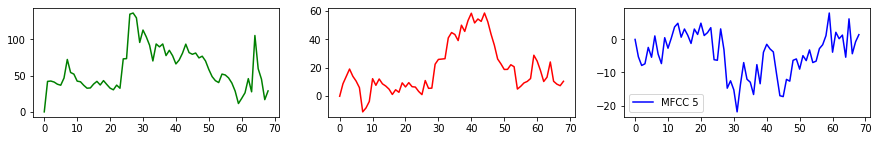

In [ ]:
plt.figure(figsize=(15,2))
plt.subplot(131,)
plt.plot(mfcc.T[:,1],'g', label='MFCC 1')
plt.subplot(132)
plt.plot(mfcc.T[:,3],'r', label='MFCC 3') 
plt.subplot(133)
plt.plot(mfcc.T[:,7],'b', label='MFCC 5') 
plt.legend()
plt.show()

# Загрузка данных 

In [ ]:
def getWayData(path, labels):

  wayFile = []
  for s in labels: 
    print('Открыли папку:',s, '---------------------')
    for w in os.listdir(os.path.join(DATA_PATH+'/'+s)): 
      wayFile.append(DATA_PATH+'/'+s+'/'+w)
      print(f'Добавил пути: {s}/{w}')
  return wayFile

In [ ]:
wayFile = getWayData(DATA_PATH, labels) # извлекаем список путей к звуковым файлам
print ('\nBсего путей к файлам данных:', len(wayFile))

Открыли папку: 1BigRoom ---------------------
Добавил пути: 1BigRoom/BigRoom (1).wav
Добавил пути: 1BigRoom/BigRoom (19).wav
Добавил пути: 1BigRoom/BigRoom (20).wav
Добавил пути: 1BigRoom/BigRoom (21).wav
Добавил пути: 1BigRoom/BigRoom (22).wav
Добавил пути: 1BigRoom/BigRoom (23).wav
Добавил пути: 1BigRoom/BigRoom (24).wav
Добавил пути: 1BigRoom/BigRoom (25).wav
Добавил пути: 1BigRoom/BigRoom (26).wav
Добавил пути: 1BigRoom/BigRoom (27).wav
Добавил пути: 1BigRoom/BigRoom (28).wav
Добавил пути: 1BigRoom/BigRoom (29).wav
Добавил пути: 1BigRoom/BigRoom (30).wav
Добавил пути: 1BigRoom/BigRoom (31).wav
Добавил пути: 1BigRoom/BigRoom (32).wav
Добавил пути: 1BigRoom/BigRoom (33).wav
Добавил пути: 1BigRoom/BigRoom (34).wav
Добавил пути: 1BigRoom/BigRoom (35).wav
Добавил пути: 1BigRoom/BigRoom (36).wav
Добавил пути: 1BigRoom/BigRoom (37).wav
Добавил пути: 1BigRoom/BigRoom (38).wav
Добавил пути: 1BigRoom/BigRoom (39).wav
Добавил пути: 1BigRoom/BigRoom (40).wav
Добавил пути: 1BigRoom/BigRoom (41)

# Составляем списк для подачи в нейроку

### Функция получения набора данных для y_Train набора. 

In [ ]:
def Ytrain (wayFile, toCategor):
  trainY = []
  d=0
  for a in wayFile:
    if d<90:
      trainY.append(toCategor[0])
    elif d<180:
      trainY.append(toCategor[1])
    elif d<270:
      trainY.append(toCategor[2])
    elif d>269:
      trainY.append(toCategor[3])
    d+=1
  return trainY 

# Извлечение данных из каждого файла.
**сортировка в три списка** 

In [ ]:
trainX1,trainX2,trainX3 = [],[],[]
trainY= []
for s in wayFile:
  yTr, srTr = librosa.load((s),       # путь к файлам для загрузки и перевода 
                      sr=SR,       # частота дискретизации 
                      mono=True,      # конвертация в моно звук (True/False)
                      offset=None,    # начало чтения файла (в секундах)
                      duration=None)  # длина отрезка звукового файла (ограничиваем по времени в сек. или нет)

  print(f'Загрузили {s}')
  ssr, chz, mfc = get_featur_mean(yTr, 22050)

  trainX1.append(ssr)
  print('trainX1 - ГОТОВ')
  trainX2.append(chz)
  print('trainX2 - ГОТОВ')
  trainX3.append(mfc)
  print('trainX3 - ГОТОВ')
yT = Ytrain(wayFile, lab_to_cat)
trainY.append(yT)
print ('trainY - ГОТОВ')
  
print ('______________Завершено!\n',
       type(trainX1),'- набор ssr\n', 
       type(trainX2),'- набор chz\n', 
       type(trainX3),'- набор mfc\n',
       type(trainY),'- набор yTrain\n')


Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (1).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (19).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (20).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (21).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (22).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (23).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1BigRoom/BigRoom (24).wav
trainX1 - ГОТОВ
trainX2 - ГОТОВ
trainX3 - ГОТОВ
Загрузили /content/drive/MyDrive/1.0AudioSmartHomme/comands/1Bi

In [ ]:
print(trainY[0][::90],'\nЗаписей:', len(trainY[0]))

[array([1., 0., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32), array([0., 0., 1., 0.], dtype=float32), array([0., 0., 0., 1.], dtype=float32)] 
Записей: 273


In [ ]:
print(len(trainY[0]), type(trainY))
npTrainY = np.array(trainY)
print('\n',npTrainY.shape, type(npTrainY))

273 <class 'list'>
(1, 273, 4) <class 'numpy.ndarray'>



# Переводм полученные данные в NP массивы и сохраняем их.


In [ ]:
print(f'Получены trainX1 {len(trainX1)} тренировочных наборов данных, в каждом наборе по {len(trainX1[0])} уникальных признаков.\n')
print(f'Получены trainX2 {len(trainX2)} тренировочных наборов данных, в каждом наборе по {len(trainX2[0])} уникальных признаков.\n')
print(f'Получены trainX3 {len(trainX3)} тренировочных наборов данных, в каждом наборе по {len(trainX3[0])} уникальных признака.\n')
print(f'Получены trainY {type(trainY)}, в наборе {len(trainY)} значения.')

Получены trainX1 273 тренировочных наборов данных, в каждом наборе по 9 уникальных признаков.

Получены trainX2 273 тренировочных наборов данных, в каждом наборе по 9 уникальных признаков.

Получены trainX3 273 тренировочных наборов данных, в каждом наборе по 3 уникальных признака.

Получены trainY <class 'list'>, в наборе 273 значения.


#### Видим: 273 примера это 3 из группы Noize + по 90 примеров из каждой группы Door, BigRoom, CamNo3
**Из каждого файла данных получено 7 групп признаков по три значения (это среднее, минимальное и максимальное).
Можно получить полный перечень значений, это будет существенно больше переменных** 

In [ ]:
# Нормализую всю имеющуюся базу для тренировки сети

trainX1 = prep.normalize(trainX1)
trainX2 = prep.normalize(trainX2)
trainX3 = prep.normalize(trainX3)

In [ ]:
# Переводим данные из листа в массив

xTrainSSR=np.array(trainX1)
xTrainCHZ=np.array(trainX2)
xTrainMFC=np.array(trainX3)
yTrainBD =np.array(trainY[0])
print('xTrainSSR', xTrainSSR.shape,'\nxTrainCHZ',xTrainCHZ.shape,'\nxTrainMFC', xTrainMFC.shape,'\nyTrainBD', yTrainBD.shape)

xTrainSSR=xTrainSSR[..., None]
xTrainCHZ=xTrainCHZ[..., None]
xTrainMFC=xTrainMFC[..., None]
print(xTrainSSR.shape, xTrainCHZ.shape, xTrainMFC.shape)

print ('Был тип:', type(trainX1), ', стал:', type(xTrainSSR),'- набор xTrainSSR\n', 
       'Был тип:', type(trainX2), ', стал:', type(xTrainCHZ),'- набор xTrainCHZ\n', 
       'Был тип:', type(trainX3), ', стал:', type(xTrainMFC),'- набор xTrainMFC', sep='')

xTrainSSR (273, 9) 
xTrainCHZ (273, 9) 
xTrainMFC (273, 3) 
yTrainBD (273, 4)
(273, 9, 1) (273, 9, 1) (273, 3, 1)
Был тип:<class 'numpy.ndarray'>, стал:<class 'numpy.ndarray'>- набор xTrainSSR
Был тип:<class 'numpy.ndarray'>, стал:<class 'numpy.ndarray'>- набор xTrainCHZ
Был тип:<class 'numpy.ndarray'>, стал:<class 'numpy.ndarray'>- набор xTrainMFC


In [ ]:
# удобно для работы с большими массивами, что-бы каждый раз не выполнять теже действия

#СОХРАНЕНИЕ ДАННЫХ
np.save(WAY_NP+'XTrain_1.npy', xTrainSSR)
np.save(WAY_NP+'XTrain_2.npy', xTrainCHZ)
np.save(WAY_NP+'XTrain_3.npy', xTrainMFC)

In [ ]:
#ЗАГРУЗКА ДАННЫХ
xTrainSSR = np.load(WAY_NP+'XTrain_1.npy', allow_pickle=True)
xTrainCHZ = np.load(WAY_NP+'XTrain_2.npy', allow_pickle=True)
xTrainMFC = np.load(WAY_NP+'XTrain_3.npy', allow_pickle=True)

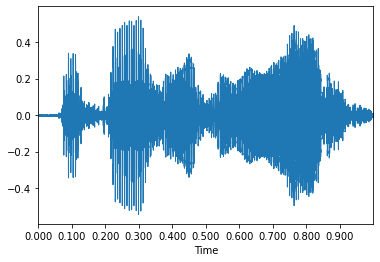

In [ ]:
''' Здесь меняя параметр sr мы получаем искажение голоса путем замедления или ускорения
    меняя размер sr в сторону увеличения или уменьшения числа'''
import librosa.display
import IPython.display as ipd

y1, sr1 = librosa.load(wayFile[97], sr=11025, offset=0.8, duration=1.0)
ipd.Audio(data=y1, rate=sr1)
librosa.display.waveplot(y1, sr1)
plt.show()

In [ ]:
print ('Оригинальный файл:')
ipd.Audio(data=y1, rate = sr1)

Оригинальный файл:


# Нейронка и обучение

In [ ]:
model = Sequential()
input1 = Input(xTrainSSR.shape[1:]) # Входные данные, это первое число размерности оцифрованых данных
input2 = Input(xTrainCHZ.shape[1:]) 
input3 = Input(xTrainMFC.shape[1:]) 

x1 = Conv1D(4,2, activation="tanh")(input1)  # На первую группу подаём тренировочные данные
x1 = BatchNormalization()(x1)                # Нормализация данных для исключения резких разниц в расчётах 
x1 = Dropout(0.1)(x1)                        # Во избежании "заучивания" произвольное отключение нейронов (коэф. 0,1 = 10%)
x1 = Conv1D(8,2, activation="tanh")(x1)      # Одномерный всёрточный слой картой 32 значения и матрицей 3 числа, производит свёртку (уменьшение)
x1 = Flatten()(x1)                           # Функция - перевод данных в вектор
x1 = Dense(64, activation='tanh')(x1)

x2 = Conv1D(4,2, activation="linear")(input2)  # На вторую группу подаём тренировочные данные
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)
x2 = Conv1D(8,2, activation="linear")(x2)
x2 = Flatten()(x2)
x2 = Dense(64, activation='linear')(x2)

x3 = Conv1D(4,2, activation="relu")(input3)    # На третью группу подаём тренировочные данные
x3 = BatchNormalization()(x3)
x3 = Dropout(0.1)(x3) 
x3 = Conv1D(8,2, activation="relu")(x3)
x3 = Flatten()(x3)
x3 = Dense(64, activation='relu')(x3)

x4=Dense(64, activation='tanh')(x2)     # Здесь данные из второй группы обрабатываем полносвязным слоем Dense на 64 нейрона
x4=Dense(64, activation='tanh')(x4)     # Обрабатываем меньшим количеством нейронов

x = concatenate([x1, x3, x4])           # Соединяем данные из групп 1, 3, 4 в группу х
x = Dense(128, activation='elu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='elu')(x)
x = concatenate([x, x4])

x = Dense(len(labels), activation='softmax')(x) # На выходе нейронов равное количеству групп


## Математическое отображение модели

In [ ]:
model = Model([input1,input2,input3],x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 8, 4)         12          input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 3, 1)]       0                                            
____________________________________________________________________________________________



---



## Графическое отображение модели

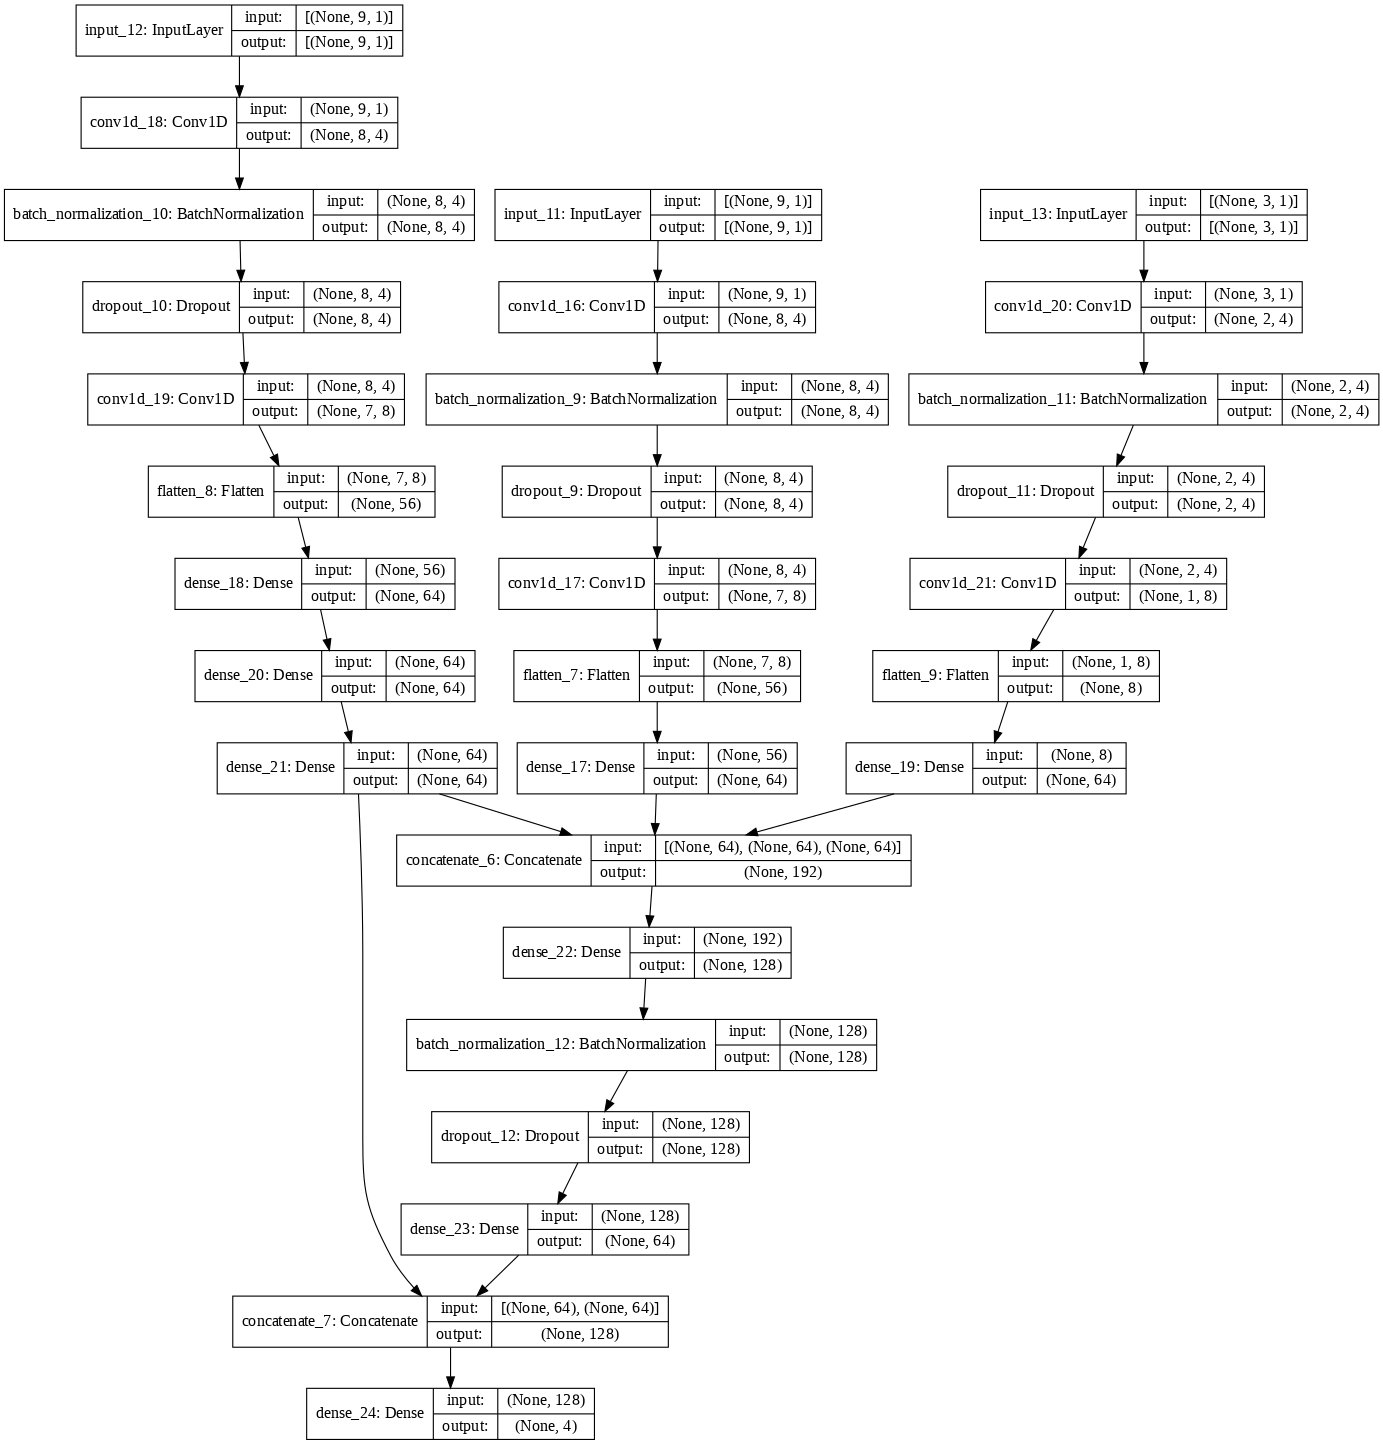

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=80)

## Сборка модели

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy',
              metrics=['accuracy'])

## ОБУЧЕНИЕ

Epoch 1/250
22/22 [==============================] - 3s 33ms/step - loss: 1.8197 - accuracy: 0.2110 - val_loss: 1.2615 - val_accuracy: 0.9455
Epoch 2/250
22/22 [==============================] - 0s 13ms/step - loss: 1.2876 - accuracy: 0.4862 - val_loss: 1.3661 - val_accuracy: 0.0000e+00
Epoch 3/250
22/22 [==============================] - 0s 16ms/step - loss: 1.0933 - accuracy: 0.5367 - val_loss: 1.4345 - val_accuracy: 0.0000e+00
Epoch 4/250
22/22 [==============================] - 0s 13ms/step - loss: 0.9801 - accuracy: 0.6055 - val_loss: 1.4963 - val_accuracy: 0.0000e+00
Epoch 5/250
22/22 [==============================] - 0s 13ms/step - loss: 0.8706 - accuracy: 0.6560 - val_loss: 1.4982 - val_accuracy: 0.0000e+00
Epoch 6/250
22/22 [==============================] - 0s 13ms/step - loss: 0.8149 - accuracy: 0.6606 - val_loss: 1.4975 - val_accuracy: 0.0000e+00
Epoch 7/250
22/22 [==============================] - 0s 13ms/step - loss: 0.7311 - accuracy: 0.7248 - val_loss: 1.5469 - val_acc

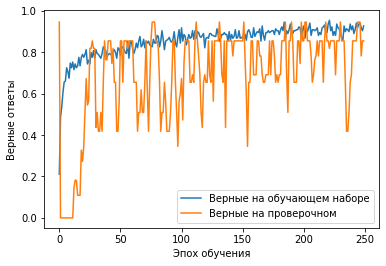

In [ ]:
history = model.fit([xTrainSSR, xTrainCHZ, xTrainMFC], yTrainBD,      # тренировочные данные для обучения
                    epochs=250,                            # количество повторений для обучения нейромодели
                    validation_split=0.2,                  # проверочные данные для контроля результата
                    batch_size=10,                         # Количество примеров для счисления до изменения весов модели
                    verbose=1)                             # параметр показывать или не показывать процесс счисления данных

plt.plot(history.history['accuracy'], label='Верные на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Верные на проверочном')
plt.xlabel('Эпох обучения')
plt.ylabel('Верные ответы')
plt.legend()
plt.show()

In [ ]:
 # Сохраняем модель
model.save_weights(WAY_NP+'Model_weight.h5')
model.save(WAY_NP+'Model_Input3_v4.h5')

 # Загружаем модель
#model.load_weights(WAY_NP+'Model_Input3_v4.h5')